# Feature Selection & Class Imbalance¶

In [1]:
#Importing libraries
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline

In [2]:
#creating a Numpy array from the csv file
mnist = np.genfromtxt('MNIST_Shortened.csv', delimiter=',', skip_header=1)

In [3]:
mnist

array([[0., 0., 0., ..., 0., 0., 9.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 4.],
       ...,
       [0., 0., 0., ..., 0., 0., 6.],
       [0., 0., 0., ..., 0., 0., 6.],
       [0., 0., 0., ..., 0., 0., 8.]])

In [4]:
#Defining X and y
X = mnist[:,0:784]
y = mnist[:,-1]

In [5]:
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [6]:
y

array([9., 0., 4., ..., 6., 6., 8.])

In [7]:
# Checking dimensions of X 
X.shape

(6000, 784)

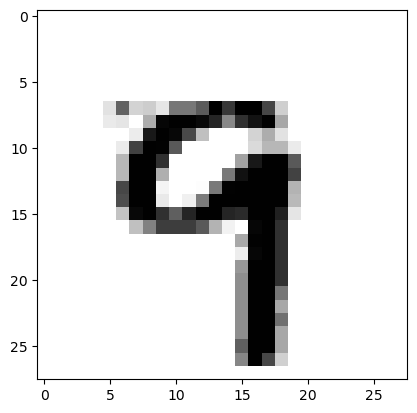

In [8]:
# using the Numpy reshape function along with the matplotlib imshow function to visualise
plt.imshow(X[0].reshape(28,28),cmap='gray_r')

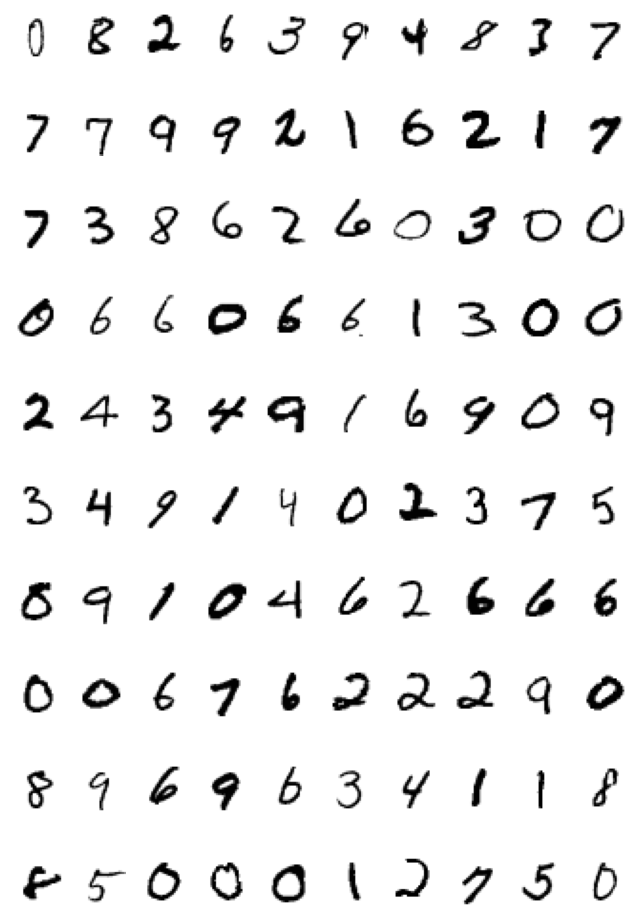

In [9]:
#selecting 100 images at random from the dataset and displaying them
plt.figure(figsize=(8, 12))
for i in range(100): 
    plt.subplot(10,10,i+1)
    plt.imshow(X[np.random.randint(0,6000)].reshape(28,28),cmap='gray_r') 
    plt.axis('off')
plt.show()

In [10]:
#spliting the data into a training dataset and a test dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

# Using VarianceThreshold to remove low or no variance features¶

In [11]:
#instantiating the selector and setting the variance threshold
from sklearn.feature_selection import VarianceThreshold 
variance_selector = VarianceThreshold(threshold=0)

In [12]:
#identifying the features below the variance threshold and transforming training array to remove them
X_train_fs = variance_selector.fit_transform(X_train)

In [13]:
#similarly transforming the test dataset
X_test_fs = variance_selector.transform(X_test)

In [14]:
print(f"{X_train.shape[1]-X_train_fs.shape[1]} features have been removed, {X_train_fs.shape[1]} features remain")

118 features have been removed, 666 features remain


<Axes: >

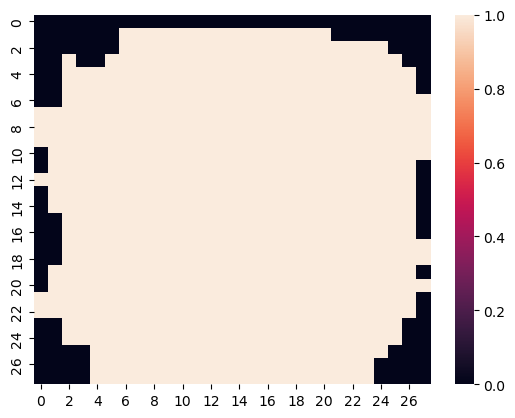

In [15]:
#viewing the features that have been dropped
#black pixels in the grid are those which have been dropped due to zero variance
selected_features = variance_selector.get_support() 
selected_features = selected_features.reshape(28,28)
sns.heatmap(selected_features,cmap='rocket')

# Filter Methods Using SelectKBest

In [16]:
# Using the SelectKBest selector from sklearn to select the k features with the best scores on a selected test statistic
from sklearn.feature_selection import SelectKBest, f_classif 
selector = SelectKBest(f_classif, k=200)
X_train_fs = selector.fit_transform(X_train_fs, y_train) 
X_test_fs = selector.transform(X_test_fs)

In [17]:
# Creaing boolean array for all features
new_features_indices =variance_selector.get_support(indices=True)[selector.get_support()]
new_features_boolean = np.isin(np.arange(784), new_features_indices)
new_features_boolean

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True,  True,  True,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True,  True,
        True,  True,

<Axes: >

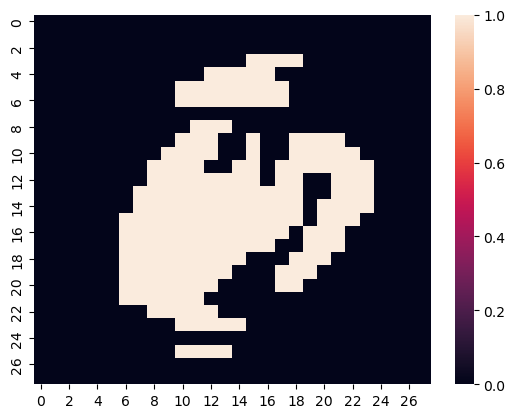

In [18]:
#Reshaping and ploting as a heatmap
sns.heatmap(new_features_boolean.reshape(28,28),cmap='rocket')

# Recursive Feature Elimination using RFECV

In [19]:
#importing from Scikit Learn
from sklearn.preprocessing import StandardScaler 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix 
from sklearn.feature_selection import RFECV

In [20]:
# Standardising data before passing to model
scaler = StandardScaler()
X_train_fs = scaler.fit_transform(X_train_fs) 
X_test_fs = scaler.transform(X_test_fs)

In [22]:
#transforming the training dataset and test dataset
# Use RandomForestClassifier as the base model
rf = RandomForestClassifier(random_state=0) 
rfecv = RFECV(rf, cv=3, step=5)
X_train_fs = rfecv.fit_transform(X_train_fs, y_train) 
X_test_fs = rfecv.transform(X_test_fs)
print(f"Number of remaining features: {X_train_fs.shape[1]}")

Number of remaining features: 190


ValueError: x and y must have same first dimension, but have shapes (41,) and (40,)

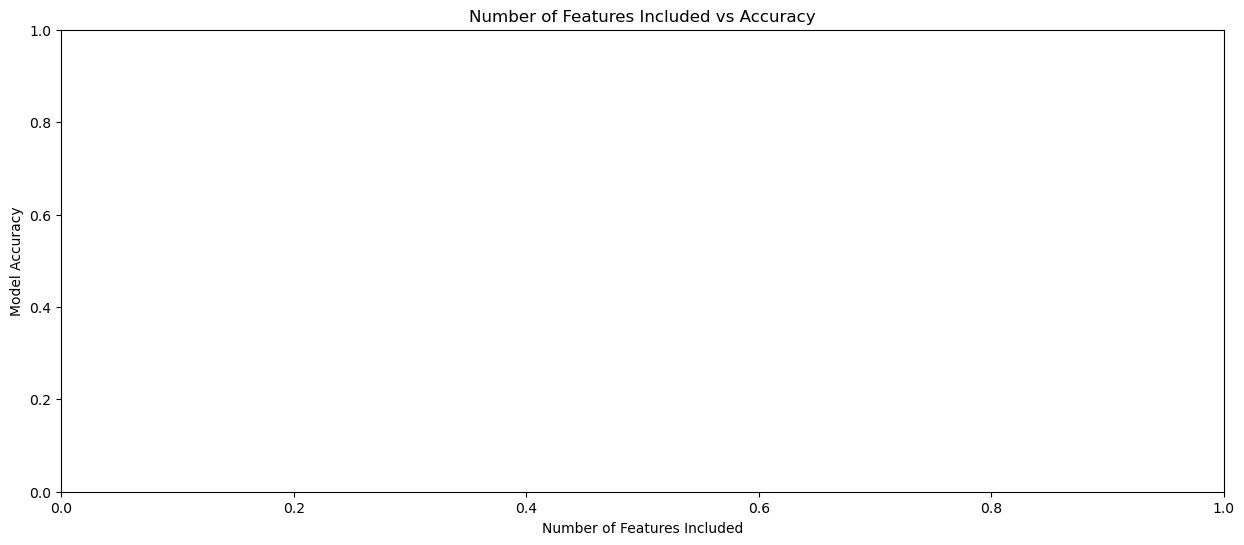

In [24]:
#plot the model accuracy against the number of features
plt.figure( figsize=(15, 6))
plt.title('Number of Features Included vs Accuracy') 
plt.xlabel('Number of Features Included') 
plt.ylabel('Model Accuracy')
plt.plot(np.linspace(0,200,41), rfecv.cv_results_['mean_test_score']) 
plt.show()

# Training and Evaluating a Model

In [23]:
#instantiating a new RandomForestClassifier model, and then fitting it to the data with the selected features
rf_selectedfeatures = RandomForestClassifier() 
rf_selectedfeatures.fit(X_train_fs, y_train)

RandomForestClassifier()

In [ ]:
#making predictions on the test dataset
y_pred = rf_selectedfeatures.predict(X_test_fs)

#evaluating using accuracy_score and confusion_matrix
print(f"Accuracy Score: {accuracy_score(y_test,y_pred)*100:.2f}%") 
cm = confusion_matrix(y_test,y_pred)
ax = sns.heatmap(cm, cmap='flare',annot=True, fmt='d')
plt.xlabel("Predicted Class",fontsize=12) 
plt.ylabel("True Class",fontsize=12) 
plt.title("Confusion Matrix",fontsize=12)
plt.show()